# Import data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
generation_data = pd.read_csv('Data\\Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('Data\\Plant_1_Weather_Sensor_Data.csv')

In [ ]:
generation_data.head()

In [ ]:
weather_data.head()

In [ ]:
generation_data.sample(5).style.set_properties(
    **{
        'background-color': 'orange',
        'color': 'black',
        'border-color': 'darkblack'
    })


In [ ]:
weather_data.sample(5).style.set_properties(
    **{
        'background-color': 'olive',
        'color': 'Black',
        'border-color': 'darkblack'
    })

# Adjust datetime format

In [ ]:
generation_data['DATE'] = pd.to_datetime(generation_data['DATE_TIME']).dt.date
generation_data['TIME'] = pd.to_datetime(generation_data['DATE_TIME']).dt.time
weather_data['DATE'] = pd.to_datetime(weather_data['DATE_TIME']).dt.date
weather_data['TIME'] = pd.to_datetime(weather_data['DATE_TIME']).dt.time

In [ ]:
generation_data['DATE_TIME'] = generation_data["DATE"].astype(str) + " " + generation_data["TIME"].astype(str)

In [ ]:
weather_data['DATE_TIME'] = weather_data["DATE"].astype(str) + " " + weather_data["TIME"].astype(str)

In [ ]:
generation_data

In [ ]:
weather_data

In [ ]:
del generation_data['DATE']
del generation_data['TIME']
del weather_data['DATE']
del weather_data['TIME']

# Converting object date_time into daytime stamping

In [ ]:
generation_data['DATE_TIME'] =  pd.to_datetime(generation_data['DATE_TIME'], format='%Y-%m-%d')

In [ ]:
generation_data.info()

In [ ]:
weather_data.info()

In [ ]:
weather_data['DATE_TIME'] =  pd.to_datetime(weather_data['DATE_TIME'], format='%Y-%m-%d')

In [ ]:
weather_data.info()


# Merging generation data and weather sensor data

In [ ]:
df_solar = pd.merge(generation_data.drop(columns = ['PLANT_ID']), weather_data.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
df_solar.sample(5).style.background_gradient(cmap='cool')

# Adding separate time and date columns

In [ ]:
# adding separate time and date columns
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.isocalendar().week


# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + (df_solar['HOURS']*60)

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.head(5)

In [ ]:
df_solar.info()

# There are no missing data

In [ ]:
df_solar.describe().style.background_gradient(cmap='rainbow')

# Converting 'SOURCE_KEY' from categorical form to numerical form

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_solar['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_solar['SOURCE_KEY'])
df_solar



# EDA

# Correlation

In [ ]:
df_solar.corr().style.background_gradient(cmap='rainbow')

In [ ]:
sns.pairplot(df_solar)

In [ ]:
plt.scatter(df_solar['IRRADIATION'],df_solar['DC_POWER'])
plt.xlabel("IRRADIATION")
plt.ylabel("DC_POWER")

In [ ]:
sns.regplot(x="IRRADIATION",y="DC_POWER",data=df_solar)

# Solar Power Prediction using different ML techniques

In [ ]:
df2 = df_solar.copy()
X = df2[['DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DC_POWER']]
y = df2['AC_POWER']
X.head()


In [ ]:
y.head()

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=21)

In [ ]:
#Standardize the dataset-gradient desent - global minimum
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [ ]:
X_train=scaler.fit_transform(X_train)

In [ ]:
X_test=scaler.transform(X_test)

In [ ]:
import pickle
pickle.dump(scaler,open('scaling.pkl','wb'))

# Model Traning

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
regression=LinearRegression()

In [71]:
regression.fit(X_train,y_train)

LinearRegression()

In [37]:
##print the cooefficients and intercepts
print(regression.coef_)

[-1.78630123e-01 -9.89300452e-04 -1.48718082e-02  1.09742958e+00
 -1.74856771e+00  3.99140723e+02]


In [38]:
print(regression.intercept_)

312.1910883814101


In [39]:
#on which parameters the model has been trained 
regression.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [40]:
##prediction with test data
reg_pred=regression.predict(X_test)

In [41]:
reg_pred

array([3.75787802e-01, 1.86198007e+02, 9.70046094e+02, ...,
       4.04346297e-02, 6.31338351e-02, 3.61140888e+02])

Text(0, 0.5, 'reg_pred')

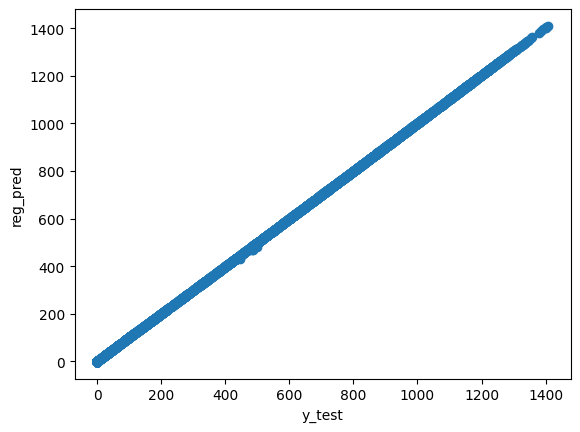

In [42]:
##plot a scatter plot for prediction
plt.scatter(y_test,reg_pred)
plt.xlabel('y_test')
plt.ylabel('reg_pred')

In [43]:
residuals=y_test-reg_pred

In [44]:
residuals

39704   -0.375788
16578    0.126993
38467    0.968191
19471   -0.462818
21836   -0.207144
           ...   
10459   -0.205915
27264   -0.194904
19030   -0.040435
12827   -0.063134
31753    1.909112
Name: AC_POWER, Length: 9136, dtype: float64

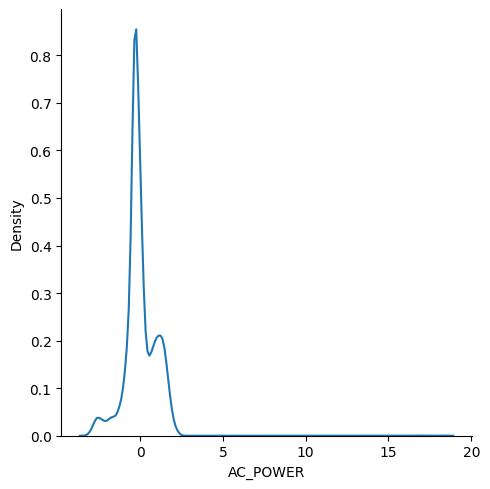

In [45]:
## ploting residuals
sns.displot(residuals,kind="kde")

Text(0, 0.5, 'residuals')

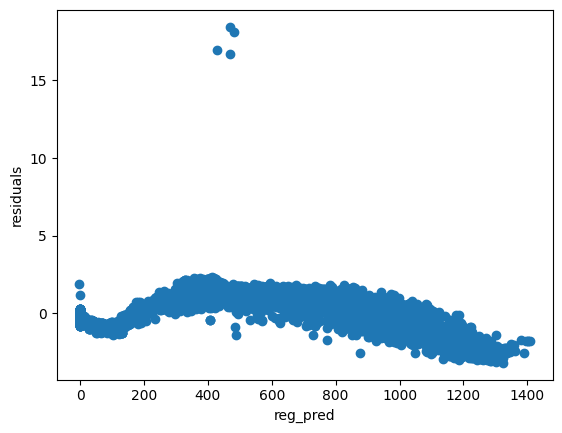

In [46]:
## scatter plot wrt prediction and residuals
plt.scatter(reg_pred,residuals)
plt.xlabel('reg_pred')
plt.ylabel('residuals')

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [48]:
print(mean_absolute_error(y_test,reg_pred))
print(mean_squared_error(y_test,reg_pred))
print(np.sqrt(mean_absolute_error(y_test,reg_pred)))

0.6604659576253403
0.9211669396181934
0.812690566959738


# R square and adjusted R square

In [49]:
## Formula 
## R^2=1-SSR/SST
## R^2= coefficient of determination SSR= sum of squares of residuals SST = total sum of square

In [50]:
from sklearn.metrics import r2_score
score = round(r2_score(reg_pred,y_test) * 100, 2)

print("R2 Score : ",score,"%")

R2 Score :  100.0 %


In [51]:
# Adjusted R2=1-[(1-R2)*(n-1)(n-k-1)]
## where:
## R2: The R2 of the model n: The number of observations k: The number of prediction 
1-(1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

100.06506736772921

# New Data prediction

In [74]:
# convert dataframe to numpy array
df2_arr = X.to_numpy()
print(df2_arr)


In [75]:
df2_arr[0].reshape(1,-1)

array([[0.00000000e+00, 6.25955900e+06, 2.51843161e+01, 2.28575074e+01,
        0.00000000e+00, 0.00000000e+00]])

In [76]:
#Transformation of new data 
scaler.transform(df2_arr[0].reshape(1,-1))
print(scaler.transform(df2_arr[0].reshape(1,-1)))

[[-1.04803565 -1.66751616 -0.20475656 -0.71264989 -0.77250794 -0.78284768]]


C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [77]:
regression.predict(scaler.transform(df2_arr[0].reshape(1,-1)))

C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.48530349])

# Pickle The model file for development

In [56]:
import pickle

In [57]:
pickle.dump(regression,open('regmodel.pkl','wb'))

In [58]:
pickled_model=pickle.load(open('regmodel.pkl','rb'))

In [59]:
## Prediction
pickled_model.predict(scaler.transform(df2_arr[0].reshape(1,-1)))

C:\Users\biswa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.48530349])